<a href="https://colab.research.google.com/github/guipantiga/Dif-in-Dif/blob/main/Dif_in_Dif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install pyspark
!pip install python-bcb
!pip install linearmodels
!pip install plotly

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import zipfile
from bcb import sgs
import requests
import ssl
from toolz import *
from scipy.special import expit
from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
import plotly.express as px

style.use("ggplot")
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# Import Spark extentions
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.dataframe import DataFrame
from pyspark.ml.feature import QuantileDiscretizer, Bucketizer
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local").appName("Colab").getOrCreate()
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

# Check Spark Session Information
spark

In [4]:
# Define global variables, this will be used to evaluate dataFrames

start_date = 2014
end_date = 2018

pre_treatment = [2014,2015]
post_treatment = [2016,2017]

evaluation_date = [2018]

In [5]:
# Open zipped dataset
# Verify the number of rows to skip, given that the dataset can be changed
with zipfile.ZipFile("/content/202309AGENCIAS.zip") as z:
  # open csv file
  with z.open("202309AGENCIAS.xlsx") as f:
    xls = pd.ExcelFile(f)
    df = xls.parse('Plan1', skiprows=9, index_col=None)

In [6]:
# Transform date format in order to join later
df['DATA INICIO TRATADA'] = df['DATA INÍCIO'].astype(str).str[:10]

In [7]:
# Verify structure and header
df.head(5)

,CNPJ,SEQUENCIAL DO CNPJ,DV DO CNPJ,NOME INSTITUIÇÃO,SEGMENTO,CÓD COMPE AG,NOME AGÊNCIA,ENDEREÇO,NÚMERO,COMPLEMENTO,BAIRRO,CEP,MUNICíPIO,UF,DATA INÍCIO,DDD,FONE,ID INSTALAÇÃO,MUNICIPIO IBGE,DATA INICIO TRATADA
0,00.000.000,2.0,72.0,BANCO DO BRASIL S.A. ...,Banco do Brasil - Banco Múltiplo ...,2.0,MANAUS ...,"R.GUILHERME MOREIRA,315",,"SUBLOJA,LOJA E 2.ANDAR ...",CENTRO,69005-300,MANAUS ...,AM,1908-01-14 00:00:00,92.0,36215500.0,9.999994e+09,1302603.0,1908-01-14
1,00.000.000,3.0,53.0,BANCO DO BRASIL S.A. ...,Banco do Brasil - Banco Múltiplo ...,3.0,PRESIDENTE VARGAS ...,"AV.PRES.VARGAS,248",,1.E 2.ANDARES ...,CAMPINA,66010-900,BELEM ...,PA,1908-07-01 00:00:00,91.0,32164888.0,9.999994e+09,1501402.0,1908-07-01
2,00.000.000,4.0,34.0,BANCO DO BRASIL S.A. ...,Banco do Brasil - Banco Múltiplo ...,4.0,SANTOS ...,"R.QUINZE DE NOVEMBRO,195",,...,CENTRO,11010-908,SANTOS ...,SP,1908-08-22 00:00:00,13.0,40097406.0,9.999994e+09,3548500.0,1908-08-22
3,00.000.000,5.0,15.0,BANCO DO BRASIL S.A. ...,Banco do Brasil - Banco Múltiplo ...,5.0,CAMPOS GOYTACAZES ...,RUA QUARTA DA JORNADA,11,PRACA DAS 04 JORNADAS ...,CENTRO,28010-510,CAMPOS DOS GOYTACAZES ...,RJ,1910-06-26 00:00:00,22.0,27370405.0,9.999994e+09,3301009.0,1910-06-26
4,00.000.000,6.0,4.0,BANCO DO BRASIL S.A. ...,Banco do Brasil - Banco Múltiplo ...,6.0,SALVADOR ...,"SEXTA AVENIDA,600",,SECRETARIA DA EDUCACAO-TERREO ...,CAB,41745-002,SALVADOR ...,BA,1910-07-15 00:00:00,71.0,33628803.0,9.999994e+09,2927408.0,1910-07-15


In [8]:
# Create spark dataFrame to manipulate
sparkAgencias = spark.createDataFrame(df)

# Get the current column names
current_columns = sparkAgencias.columns

# Trim spaces in column names and create a mapping of old names to new names
column_name_mapping = {col_name: col_name.strip() for col_name in current_columns}

# Apply the column name trimming and renaming
sparkAgencias = sparkAgencias.select([F.col(col_name).alias(column_name_mapping[col_name]) for col_name in current_columns])


In [9]:
dfAgencias = (sparkAgencias
              .filter(~F.col('CNPJ').isNull())
              .select(
                  'CNPJ',
                  F.col('ID INSTALAÇÃO').alias('ID_INSTALACAO'),
                  F.trim('NOME INSTITUIÇÃO').alias('NOME_INSTITUICAO'),
                  F.trim('NOME AGÊNCIA').alias('NOME_AGENCIA'),
                  F.col('SEGMENTO').alias('SEGMENTO'),
                  'CEP',
                  F.col('MUNICÍPIO').alias('MUNICIPIO'),
                  F.col('DATA INICIO TRATADA').alias('DATA_INICIO_TRATADA'),
                  F.col('MUNICIPIO IBGE').cast('bigint').alias('CD_MUNICIPIO')
                  )
              .withColumn('ANO_AGENCIA', F.col('DATA_INICIO_TRATADA').substr(1,4).cast('int'))
              #Create an auxiliar date in order to join with PIB table, this date is going to add up to an year
              .withColumn('ANO_REFERENCIA', (F.add_months(F.col('DATA_INICIO_TRATADA'), 12*1)).substr(1,4).cast('int'))
              .filter(~F.col('ANO_REFERENCIA').isNull())
              )

In [10]:
(dfAgencias.groupBy('ANO_AGENCIA').count().alias('QUANTIDADE_AGENCIAS').orderBy('ANO_AGENCIA')).toPandas()

,ANO_AGENCIA,count
0,1908,3
1,1910,2
2,1911,2
3,1913,2
4,1915,1
...,...,...
106,2019,200
107,2020,122
108,2021,156
109,2022,149


In [11]:
dfAgenciasPd = dfAgencias.toPandas()

In [12]:
import plotly.express as px

fig = px.histogram(dfAgenciasPd.query("ANO_AGENCIA <= 2019"), x="ANO_AGENCIA")

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

fig.add_vrect(x0=2014, x1=2018, line_width=0, fillcolor="red", opacity=0.2)

# Edit the layout
fig.update_layout(title='Quantidade de Novas Agências por Ano',
                   xaxis_title='Período no tempo',
                   yaxis_title='Quantidade de Agências Bacárias')

fig.show()

In [13]:
import plotly.graph_objects as go

dfGraphQueryed = dfAgenciasPd.query("ANO_AGENCIA <= 2019").copy()

fig = go.Figure(data=[go.Histogram(x=dfGraphQueryed['ANO_AGENCIA'], cumulative_enabled=True)])

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

fig.add_vrect(x0=2014, x1=2018, line_width=0, fillcolor="red", opacity=0.2)

# Edit the layout
fig.update_layout(title='Quantidade Acumulada de Agências por Ano',
                   xaxis_title='Período no tempo',
                   yaxis_title='Quantidade de Agências Bacárias')

fig.show()

In [14]:
import plotly.express as px

dfAgenciasPdQueried = dfAgenciasPd.query("ANO_AGENCIA >= 2014 and ANO_AGENCIA < 2019").copy()
dfAgenciasPdQueried['ANO_REF'] = dfAgenciasPdQueried['ANO_AGENCIA'].astype(str)
dfAgenciasPdQueried.sort_values('ANO_AGENCIA')

fig = px.histogram(dfAgenciasPdQueried, x="ANO_AGENCIA", text_auto=True)

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

# Edit the layout
fig.update_layout(title='Quantidade de Novas Agências por Ano no Período de 2014 a 2018',
                   xaxis_title='Período no tempo',
                   yaxis_title='Quantidade de Agências Bacárias')

fig.update_layout(bargap=0.2)

fig.show()

In [15]:
import plotly.express as px
import plotly.graph_objects as go

dfAgenciasPdSorted = (dfAgencias
 .join(
     dfAgencias
     .filter(F.col('ANO_AGENCIA').between(2014,2018))
     .groupBy('SEGMENTO').count().orderBy('count', ascending=False)
     , on = ['SEGMENTO']
     , how ='left'
 ).orderBy('count', ascending=False)
).toPandas()

dfAgenciasPdQueried = dfAgenciasPdSorted.query("ANO_AGENCIA >= 2014 and ANO_AGENCIA < 2019").copy()
dfAgenciasPdQueried['ANO_REF'] = dfAgenciasPdQueried['ANO_AGENCIA'].astype(str)
dfAgenciasPdQueried.sort_values('SEGMENTO')

fig = px.histogram(dfAgenciasPdQueried, x="SEGMENTO", nbins=4, text_auto=True)

# fig = go.Figure(data=[go.Histogram(x=dfAgenciasPdQueried.SEGMENTO, cumulative_enabled=True)])

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

# Edit the layout
fig.update_layout(title='Quantidade de Agências por Segmento no período de 2014 a 2018',
                   xaxis_title='Segmento',
                   yaxis_title='Quantidade de Agências Bacárias')

fig.update_layout(bargap=0.2)

fig.show()

In [16]:
(dfAgencias
     .filter(F.col('ANO_AGENCIA').between(2014,2018))
     .groupBy('SEGMENTO').agg(F.count('ID_INSTALACAO').alias('qtd'))
     .orderBy('qtd', ascending=False)).toPandas()

,SEGMENTO,qtd
0,Banco Múltiplo ...,473
1,Banco do Brasil - Banco Múltiplo ...,229
2,Caixa Econômica Federal ...,127
3,Sociedade Corretora de Câmbio ...,25
4,Sociedade Corretora de TVM ...,17
5,Sociedade Distribuidora de TVM ...,14
6,Associação de Poupança e Empréstimo ...,10
7,"Sociedade de Crédito, Financiamento e Investim...",8
8,Sociedade de Crédito ao Microempreendedor ...,6
9,Sociedade de Arrendamento Mercantil ...,5


In [17]:
# Open zipped dataset
zipfile.ZipFile("/content/base_de_dados_2010_2021_xlsx.zip")

with zipfile.ZipFile("/content/base_de_dados_2010_2021_xlsx.zip") as z:
  # open csv file
  with z.open("PIB dos Municípios - base de dados 2010-2021.xlsx") as f:
    xls = pd.ExcelFile(f)
    df = xls.parse(index_col=None)

In [18]:
# Create spark dataFrame
sparkPIB = spark.createDataFrame(df)

In [19]:
# Create columns in order to join dataframes
dfPIBMunicipios = (sparkPIB
                   .select(
                       F.col('Ano').cast('int').alias('ANO_REFERENCIA'),
                       F.col('Nome da Grande Região').alias('NOME_MACRO_REGIAO'),
                       F.col('Hierarquia Urbana (principais categorias)').alias('NOME_HIERARQUIA_URBANA'),
                       F.col('Código do Município').cast('bigint').alias('CD_MUNICIPIO'),
                       F.col('Produto Interno Bruto per capita, \na preços correntes\n(R$ 1,00)').cast('bigint').alias('PIB_PER_CAPTA'),
                       F.col('Atividade com maior valor adicionado bruto').alias('ATIVIDADE_PRIMARIA')
                       )
                   .withColumn('PIB_BEFORE', (F.lag('PIB_PER_CAPTA').over(Window.partitionBy('CD_MUNICIPIO').orderBy('ANO_REFERENCIA'))))
                   .withColumn('PIB_DIFF', ((F.col('PIB_PER_CAPTA')/F.col('PIB_BEFORE'))-1).cast('decimal(19,2)'))
                   .orderBy('ANO_REFERENCIA')
                   .filter(F.col('PIB_DIFF').isNotNull())
                   .dropDuplicates()
                   )

In [20]:
dfPIBMunicipiosPd = dfPIBMunicipios.toPandas()

In [21]:
dfPIBMunicipiosPd.head(5)

,ANO_REFERENCIA,NOME_MACRO_REGIAO,NOME_HIERARQUIA_URBANA,CD_MUNICIPIO,PIB_PER_CAPTA,ATIVIDADE_PRIMARIA,PIB_BEFORE,PIB_DIFF
0,2011,Norte,Centro Local,1100015,11577,"Administração, defesa, educação e saúde públic...",10731,0.08
1,2012,Norte,Centro Local,1100015,13670,"Administração, defesa, educação e saúde públic...",11577,0.18
2,2013,Norte,Centro Local,1100015,13266,"Administração, defesa, educação e saúde públic...",13670,-0.03
3,2014,Norte,Centro Local,1100015,14727,"Administração, defesa, educação e saúde públic...",13266,0.11
4,2015,Norte,Centro Local,1100015,16471,"Administração, defesa, educação e saúde públic...",14727,0.12


In [22]:
import plotly.express as px

fig = px.line(
    dfPIBMunicipiosPd
    .query("ANO_REFERENCIA >= 2014 and ANO_REFERENCIA <= 2018")
    .groupby(["ANO_REFERENCIA","NOME_MACRO_REGIAO"])["PIB_PER_CAPTA"]
    .mean()
    .reset_index(),
    x="ANO_REFERENCIA",
    y="PIB_PER_CAPTA",
    color='NOME_MACRO_REGIAO'
    )

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

# Edit the layout
fig.update_layout(title='PIB médio dos municípios por Ano no Período de 2014 a 2018',
                   xaxis_title='Período no tempo',
                   yaxis_title='PIB per capita')

fig.show()

In [23]:
import plotly.express as px

fig = px.line(
    dfPIBMunicipiosPd
    .query("ANO_REFERENCIA >= 2014 and ANO_REFERENCIA <= 2018")
    .groupby(["ANO_REFERENCIA"])["PIB_PER_CAPTA"]
    .mean()
    .reset_index(),
    x="ANO_REFERENCIA",
    y="PIB_PER_CAPTA",
    markers=True
    )

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

# Edit the layout
fig.update_layout(title='PIB Médio dos municípios para os períodos de 2014 a 2018',
                   xaxis_title='Período no tempo',
                   yaxis_title='PIB per capita médio')

fig.show()

In [24]:
# Join bank agencies with PIB

dfJoinedInfos = (dfAgencias
                 .filter(F.col('ANO_AGENCIA').between(2014,2018))
                  .join(
                      dfPIBMunicipios
                      .withColumn('ANO_AGENCIA', F.col('ANO_REFERENCIA'))
                      .select('CD_MUNICIPIO','ANO_AGENCIA','PIB_PER_CAPTA','NOME_MACRO_REGIAO')
                      .dropDuplicates()
                      , on = ['CD_MUNICIPIO','ANO_AGENCIA']
                      , how = 'left'
                  )
                  )

In [25]:
dfJoinedInfosPd = (dfJoinedInfos
                   .groupBy('NOME_MACRO_REGIAO','CD_MUNICIPIO')
                   .agg(
                       F.count('ID_INSTALACAO').alias('QTD_AGENCIAS'),
                       F.avg('PIB_PER_CAPTA').alias('PIB_MEDIO')
                       )
                   ).toPandas()

In [27]:
dfJoinedInfosPd['QTD_AGENCIAS'].corr(dfJoinedInfosPd['PIB_MEDIO'], method='pearson')

0.056749048258007966

In [28]:
dfJoinedInfosPd['QTD_AGENCIAS'].corr(dfJoinedInfosPd['PIB_MEDIO'], method='spearman')

0.43561402303274044

In [29]:
dfJoinedInfosPdNumbaTchu = (dfJoinedInfos
                   .groupBy('NOME_MACRO_REGIAO')
                   .agg(
                       F.count('ID_INSTALACAO').alias('QTD_AGENCIAS'),
                       F.avg('PIB_PER_CAPTA').cast('int').alias('PIB_MEDIO')
                       )
                   ).toPandas()

<ipython-input-31-2603a23f6dbd>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




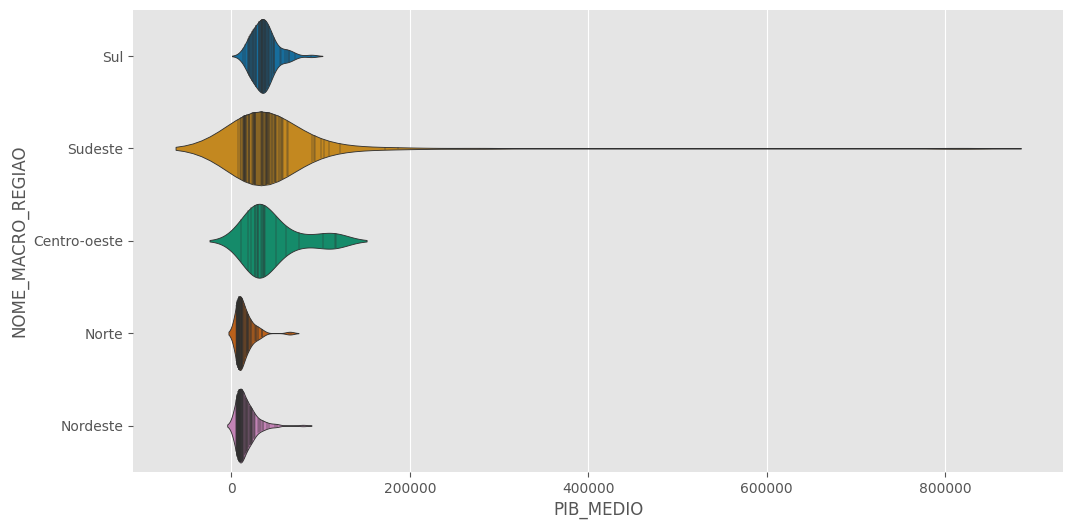

In [31]:
# @title NOME_MACRO_REGIAO vs PIB_MEDIO

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(dfJoinedInfosPd['NOME_MACRO_REGIAO'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(dfJoinedInfosPd, x='PIB_MEDIO', y='NOME_MACRO_REGIAO', inner='stick', palette='colorblind')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-32-c41ae09c863f>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




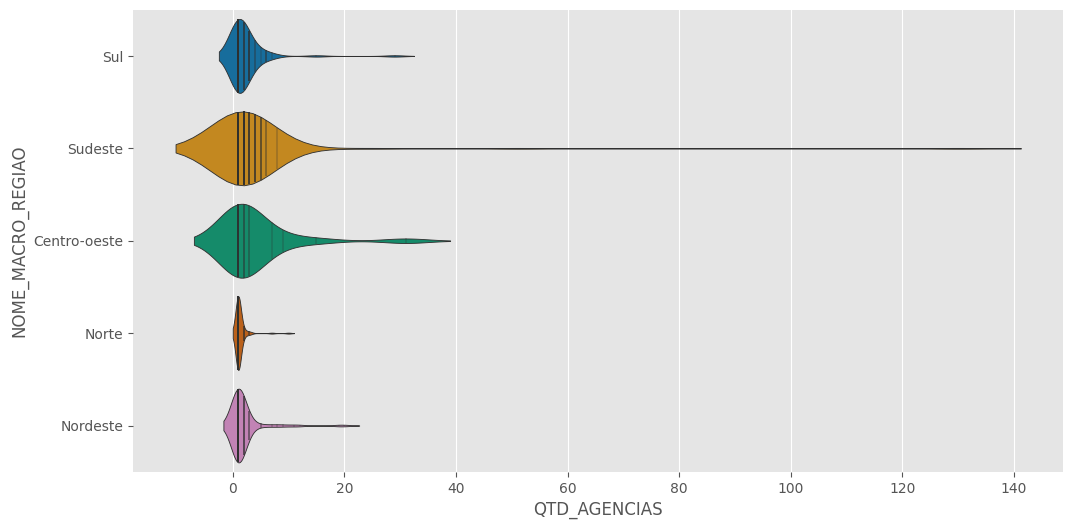

In [32]:
# @title NOME_MACRO_REGIAO vs QTD_AGENCIAS

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(dfJoinedInfosPd['NOME_MACRO_REGIAO'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(dfJoinedInfosPd, x='QTD_AGENCIAS', y='NOME_MACRO_REGIAO', inner='stick', palette='colorblind')
sns.despine(top=True, right=True, bottom=True, left=True)

In [33]:
fig = px.scatter(dfJoinedInfosPd, x="PIB_MEDIO", y="QTD_AGENCIAS", color="NOME_MACRO_REGIAO", hover_data='CD_MUNICIPIO')

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

# Edit the layout
fig.update_layout(title='Relação de Quantidade de Agências versus PIB médio dos Municípios para os Períodos de 2014 a 2018',
                   xaxis_title='PIB Médio',
                   yaxis_title='Quantidade de Agências Bancárias')

fig.show()

In [34]:
# Let us take time to create the treatment effect given that any agency was create at that time
dfAgenciasTreatment = (dfAgencias
                       .filter(F.col('ANO_AGENCIA') <= end_date)
                       .groupBy('CD_MUNICIPIO','ANO_AGENCIA')
                       .agg(F.count('CNPJ').alias('QTD_AGENCIAS'))
                       .withColumn('TREATMENT', F.lit(1))
                       .withColumn('ANO_REFERENCIA', F.col('ANO_AGENCIA'))
                       )

# We also have to take into account that the agency that has been opened is still in operation,
dfAgenciasTimeless = (dfAgenciasTreatment
                      .groupBy('CD_MUNICIPIO')
                      .agg(
                          F.sum('QTD_AGENCIAS').alias('QTD_AGENCIAS_TOTAL'),
                          F.min('ANO_REFERENCIA').alias('FIRST_YEAR_AGENCY')
                          )
                      .filter(F.col('FIRST_YEAR_AGENCY') <= end_date)
                      )

# We must get the minimun value from our database in order to evaluate properly if we are going to take into account that agency
dfMinimunValue = (dfPIBMunicipios
                  .groupBy('CD_MUNICIPIO')
                  .agg(
                      F.min('ANO_REFERENCIA').alias('MIN_ANO_REFERENCIA')
                      )
                  )

In [35]:
# Lets evaluate only 2020 and 2021. By this time, PIX (a new and free payment method) and Covid was already in place in Brazil
def get_evaluation_dates(
  df,
  start_date: int,
  end_date: int
):
  df = (df
        .filter(F.col('ANO_REFERENCIA').between(start_date,end_date))
        )

  return df


dfPIBMunicipiosFiltered = get_evaluation_dates(
    dfPIBMunicipios,
    start_date = start_date,
    end_date = end_date
    )

# We can have 4 different configurations for this data frame:

1.   that city did NOT HAVE an agency before and did NOT HAVE a new one in the
2.   that city did HAVE an agency before and did NOT HAVE a new one in the period
3.   that city did HAVE an agency before and NOW has one
4.   that city did NOT HAVE an agency before and NOW has one

For this exercise, we are going to consider 2 and 3 as not valid and give them both number 2

In [36]:
dfJoinedTables = (dfPIBMunicipiosFiltered
                  .join(
                      dfAgenciasTreatment
                      , on = ['ANO_REFERENCIA','CD_MUNICIPIO']
                      , how = 'left'
                      )
                  .join(
                      dfAgenciasTimeless
                      , on = ['CD_MUNICIPIO']
                      , how = 'left'
                      )
                  .join(
                      dfMinimunValue
                      , on = ['CD_MUNICIPIO']
                      , how = 'left'
                      )
                  .withColumn('FL_PRE_TREATMENT',
                              F.when(
                                  (F.col('ANO_REFERENCIA').isin(*pre_treatment))
                                  & (F.col('ANO_AGENCIA').isNull())
                                  , F.lit(1)
                                  ).otherwise(F.lit(0))
                  )
                  .withColumn('FL_POST_TREATMENT',
                              F.when(
                                  (F.col('ANO_AGENCIA').isin(*post_treatment)), F.lit(1)
                                  ).otherwise(F.lit(0))
                  )
                  .withColumn('FL_DELETE_TREATMENT',
                              F.when(
                                  ((F.col('FIRST_YEAR_AGENCY') <= F.lit(max(pre_treatment)))), F.lit(1)
                                  ).otherwise(F.lit(0))
                  )
                  .fillna(0)
                  .drop('REMOVE','MIN_ANO_REFERENCIA')
                  .filter(F.col('FL_DELETE_TREATMENT') == 0)
                  )

In [37]:
dfCreateGroups = (dfJoinedTables
 .filter(F.col('FL_DELETE_TREATMENT') == 0)
 .groupBy('CD_MUNICIPIO')
 .agg(
     F.max('FL_PRE_TREATMENT').alias('FL_PRE_TREATMENT'),
     F.max('FL_POST_TREATMENT').alias('FL_POST_TREATMENT'),
 )
 .withColumn('GROUP',
             F.when(
                 (F.col('FL_PRE_TREATMENT') == 1)
                 & (F.col('FL_POST_TREATMENT') == 1)
                 , F.lit('TRATAMENTO')
                 )
             .when(
                 (F.col('FL_PRE_TREATMENT') == 1)
                 & (F.col('FL_POST_TREATMENT') == 0)
                 , F.lit('CONTROLE')
                 )
             .otherwise(F.lit('OTHER'))
             )
 )

In [38]:
dfTreated = (dfJoinedTables
              .join(
                  dfCreateGroups.select('CD_MUNICIPIO','GROUP')
                  , on = ['CD_MUNICIPIO']
                  , how = 'inner'
              )
                .dropDuplicates()
                .drop('QTD_TIMES_APPEARED')
                .orderBy('CD_MUNICIPIO','ANO_REFERENCIA')
                .withColumn('TREATMENT_BEFORE', (F.lag('TREATMENT').over(Window.partitionBy('CD_MUNICIPIO').orderBy('ANO_REFERENCIA'))))
                .fillna(0)
                .drop(
                    'FL_PRE_TREATMENT',
                    'FL_POST_TREATMENT',
                    'FL_DELETE_TREATMENT',)
                 .withColumn('DETAILED_TIME_PERIOD',
                              F.when(
                                  F.col('ANO_REFERENCIA').isin(*pre_treatment), F.lit('1 - PRE_TREATMENT')
                                  )
                              .when(
                                  F.col('ANO_REFERENCIA').isin(*post_treatment), F.lit('2 - DURING_TREATMENT')
                                  )
                              .when(
                                  F.col('ANO_REFERENCIA').isin(*evaluation_date), F.lit('3 - POST_TREATMENT')
                                  )
                              )
                 .withColumn('TIME_PERIOD',
                              F.when(
                                  F.col('ANO_REFERENCIA').isin(*pre_treatment,*post_treatment), F.lit('1 - BEFORE_TREATMENT')
                                  )
                              .when(
                                  F.col('ANO_REFERENCIA').isin(*evaluation_date), F.lit('2 - POST_TREATMENT')
                                  )
                              )
              )

In [39]:
# Compare detailed metrics
(dfTreated
 .groupBy('DETAILED_TIME_PERIOD')
 .pivot('GROUP')
 .agg(
     F.mean('PIB_PER_CAPTA').cast('bigint').alias('AVG_PIB_PER_CAPTA'),
     )
 .orderBy('DETAILED_TIME_PERIOD')
 ).show(30, False)

 # Compare metrics
dfMetrics = (dfTreated
            .groupBy('TIME_PERIOD')
            .pivot('GROUP')
            .agg(
                F.mean('PIB_PER_CAPTA').cast('bigint').alias('AVG_PIB_PER_CAPTA'),
                )
            .orderBy('TIME_PERIOD')
            ).persist()

dfMetrics.show(30, False)

+--------------------+--------+----------+
|DETAILED_TIME_PERIOD|CONTROLE|TRATAMENTO|
+--------------------+--------+----------+
|1 - PRE_TREATMENT   |14273   |17740     |
|2 - DURING_TREATMENT|16565   |25635     |
|3 - POST_TREATMENT  |17947   |34160     |
+--------------------+--------+----------+

+--------------------+--------+----------+
|TIME_PERIOD         |CONTROLE|TRATAMENTO|
+--------------------+--------+----------+
|1 - BEFORE_TREATMENT|15419   |21687     |
|2 - POST_TREATMENT  |17947   |34160     |
+--------------------+--------+----------+



In [40]:
dfCopy = (dfTreated
          .withColumn('YEAR',F.col('ANO_REFERENCIA'))
          .withColumn('CONTROL_GROUP', F.when(F.col('GROUP') == 'TRATAMENTO', F.lit(1)).otherwise(F.lit(0)))
          .withColumn('TIME_FRAME', F.when(F.col('ANO_REFERENCIA').isin(*evaluation_date), F.lit(1)).otherwise(F.lit(0)))
          .select('YEAR','PIB_PER_CAPTA','CONTROL_GROUP','TIME_FRAME')
          ).toPandas()

In [41]:
treated_before = dfCopy.query("CONTROL_GROUP==1 & TIME_FRAME==0")["PIB_PER_CAPTA"].mean()

treated_after = dfCopy.query("CONTROL_GROUP==1 & TIME_FRAME==1")["PIB_PER_CAPTA"].mean()

control_after = dfCopy.query("CONTROL_GROUP==0 & TIME_FRAME==1")["PIB_PER_CAPTA"].mean()

control_before = dfCopy.query("CONTROL_GROUP==0 & TIME_FRAME==0")["PIB_PER_CAPTA"].mean()

diff_in_diff = (treated_after-treated_before)-(control_after-control_before)
print(f"Estimador simples de diferenças em diferenças. Resultado esperado de aumento de PIB per capita em R$ de: " + str(diff_in_diff))

Estimador simples de diferenças em diferenças. Resultado esperado de aumento de PIB per capita em R$ de: 9944.659208902125


In [42]:
import plotly.graph_objects as go
# Add data
time_eval = ['Pré Tratamento', 'Pós Tratamento']
control_eval = [control_before, control_after]
treatment_eval = [treated_before, treated_after]
conterfactual_eval = [treated_before, treated_before+(control_after-control_before)]

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=time_eval, y=control_eval, name='CONTROL_GROUP = 0',
                         line=dict(color='royalblue', width=2)
                         )
)
fig.add_trace(go.Scatter(x=time_eval, y=treatment_eval, name = 'CONTROL_GROUP = 1',
                         line=dict(color='tomato', width=2)
                         )
)
fig.add_trace(go.Scatter(x=time_eval, y=conterfactual_eval, name='Counterfactual',
                         line=dict(color='tomato', width=3,
                              dash='dash')
))

# Edit the layout
fig.update_layout(title='Representação gráfica do Antes e Depois do Tratamento em Municípios',
                   xaxis_title='Período no tempo',
                   yaxis_title='PIB per capita')

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

fig.show()

In [47]:
plt.figure(figsize=(10,4))
# sns.lineplot(
#     data=(dfCopy
#           .groupby(["CONTROL_GROUP", "YEAR"])["PIB_PER_CAPTA"]
#           .mean()
#           .reset_index()),
#     x="YEAR",
#     y = "PIB_PER_CAPTA",
#     hue="CONTROL_GROUP",
# )

dfCopy['ANO_REF'] = dfCopy['YEAR'].astype(str)

fig = px.line(
    dfCopy
    .groupby(["CONTROL_GROUP", "ANO_REF"])["PIB_PER_CAPTA"]
    .mean()
    .reset_index(),
    x='ANO_REF',
    y='PIB_PER_CAPTA',
    color='CONTROL_GROUP',
    markers=True,
    line_shape='spline'
    )
# fig.add_vline(x=2, line_width=2, line_dash="dash", line_color="black", annotation_text="Alocação de Agência",)

# fig.add_vrect(x0=2014, x1=2018, line_width=0, fillcolor="red", opacity=0.2)

# Edit the layout
fig.update_layout(title='Análise do histórico de PIB per capita médio por ano',
                   xaxis_title='Ano de Referência',
                   yaxis_title='PIB per capita')

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)



fig.show()

<Figure size 1000x400 with 0 Axes>

In [44]:
ols = smf.ols('PIB_PER_CAPTA ~ CONTROL_GROUP*TIME_FRAME', data=dfCopy).fit()

In [45]:
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          PIB_PER_CAPTA   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     28.65
Date:                Mon, 15 Apr 2024   Prob (F-statistic):           1.88e-18
Time:                        13:25:23   Log-Likelihood:            -1.4046e+05
No. Observations:               12630   AIC:                         2.809e+05
Df Residuals:                   12626   BIC:                         2.809e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               